In [40]:
import google.generativeai as genai
import os
import csv
import json

In [3]:
API_KEY = open("GeminiKey.txt").read().strip()
genai.configure(api_key=API_KEY)

In [4]:
def inizializza_modello(model_name="gemini-1.5-pro-latest"):
    """Inizializza il modello GenerativeModel."""
    try:
        model = genai.GenerativeModel(model_name=model_name)
        print(f"Modello Gemini '{model_name}' inizializzato correttamente.")
        return model
    except Exception as e:
        print(f"Errore durante l'inizializzazione del modello '{model_name}': {e}")
        return None

In [11]:
ANALYSIS_PROMPT_TEMPLATE = """Analizza il testo fornito. Il tuo compito è duplice:

Identificare tutte le persone menzionate nel testo verso cui l'autore esprime una chiara emozione.
Per ognuna di queste persone, determinare l'emozione predominante espressa nei suoi confronti, scegliendola esclusivamente dalla seguente lista di cinque: gioia, tristezza, rabbia, paura, sorpresa.
Restituisci il risultato come una lista di oggetti JSON. Ogni oggetto JSON deve contenere esattamente due chiavi:
L'OUTPUT DEV'ESSERE PER FORZA FORMATTATO IN JSON
"soggetto": una stringa con il nome della persona identificata.
"emozione_dominante": una stringa che rappresenta l'emozione predominante (scelta dalla lista sopra).
Linee Guida Importanti:
L'OUTPUT DEV'ESSERE PER FORZA FORMATTATO IN JSON
Includi una persona nell'analisi anche se non è il soggetto principale dell'intero messaggio, purché un'emozione chiara (dalla lista specificata) sia espressa nei suoi confronti.
Se una persona è menzionata più volte con la stessa emozione dominante nel contesto del messaggio, includila una sola volta nell'output finale.
Se nel testo non vengono identificate persone verso cui è espressa una chiara emozione dalla lista fornita, o se nessuna delle cinque emozioni si applica chiaramente a un soggetto identificabile, restituisci una lista JSON vuota [].
Ecco alcuni esempi di come elaborare i messaggi:
L'OUTPUT DEV'ESSERE PER FORZA FORMATTATO IN JSON
Messaggio 1: "Romeo ma con Wes la prossima estate saremo punto e a capo, ha rinnovato per una sola stagione..."
Output JSON atteso per Messaggio 1:

JSON

[
  {
    "soggetto": "Wes",
    "emozione_dominante": "tristezza"
  }
]
Messaggio 2: "Ma se posso chiedere una cosa, NICO dov e?"
Output JSON atteso per Messaggio 2:

JSON

[
  {
    "soggetto": "NICO",
    "emozione_dominante": "sorpresa"
  }
]
Messaggio 3: "Sono felicissimo per Marco che ha finalmente ottenuto la promozione, anche se questo significa che Elena sarà sovraccarica di lavoro e ne è preoccupata."
Output JSON atteso per Messaggio 3:

JSON

[
  {
    "soggetto": "Marco",
    "emozione_dominante": "gioia"
  },
  {
    "soggetto": "Elena",
    "emozione_dominante": "paura"
  }
]
Messaggio 4 (nuovo esempio per illustrare l'analisi dettagliata):
Testo: "Sento molti dire che Danilo non deve più giocare, ma non è diventato un brocco, è solo fuori condizione. E far giocare un calciatore così è un errore dell'allenatore! Danilo merita rispetto."
Output JSON atteso per Messaggio 4:

JSON

[
  {
    "soggetto": "Danilo",
    "emozione_dominante": "tristezza"
  },
  {
    "soggetto": "allenatore",
    "emozione_dominante": "rabbia"
  }
]

Messaggio 5: "Luca mi ha detto che il progetto è annullato. Che rabbia!"
Output JSON atteso per Messaggio 5:

JSON

[]
(Spiegazione per l'esempio 5: La rabbia è del parlante e non è diretta specificamente verso Luca, che agisce solo da messaggero in questo contesto.)

Messaggio 6: "Solo a me ancora questa Juve non mi sembra niente di speciale?"

JSON

[
  {
    "soggetto": "Juve",
    "emozione_dominante": "tristezza"
  }
]

Messaggio 7: ""Thiago Motta non si tocca e McKennie è un Marines Texano! Per quanto riguarda Douglas Luiz no vedo l'ora che rientri e si ritagli un posto nella rosa, proprio al posto di Weston, Weah e Thuram li farei giocare sempre e contro il Lille vinciamo 0-2. Fare bottino pieno per noi è fondamentale e la rosa è valida e pronta per il futuro prossimo che io vedo roseo.🦓"

[
  {
    "soggetto": "Thiago Motta",
    "emozione_dominante": "gioia"
  },
  {
    "soggetto": "McKennie",
    "emozione_dominante": "gioia"
  },
  {
    "soggetto": "Douglas Luiz",
    "emozione_dominante": "gioia"
  },
  {
    "soggetto": "Weah",
    "emozione_dominante": "gioia"
  },
  {
    "soggetto": "Thuram",
    "emozione_dominante": "gioia"
  },
  {
    "soggetto": "Juve",
    "emozione_dominante": "gioia"
  }
]
Ora analizza il seguente messaggio:

{message_to_analyze}
L'OUTPUT DEV'ESSERE PER FORZA FORMATTATO IN JSON
"""

In [12]:
def analizza_messaggio(model, messaggio_testo):
    """
    Invia un messaggio al modello Gemini per l'analisi soggetto-emozione.
    Restituisce la risposta JSON come stringa.
    """
    if not model:
        print("Errore: Modello non inizializzato.")
        return "[]"
        
    if not messaggio_testo or not messaggio_testo.strip():
        # print("Messaggio vuoto, skipping.") # Log opzionale
        return "[]" # Restituisce una lista JSON vuota per messaggi vuoti

    prompt_completo = ANALYSIS_PROMPT_TEMPLATE.replace("{message_to_analyze}", messaggio_testo)
    
    try:
        # print(f"\n💬 Analisi del messaggio: \"{messaggio_testo[:100].strip()}...\"") # Rimosso per output più pulito se si processano molti file
        response = model.generate_content(prompt_completo)
        
        cleaned_response_text = response.text.strip()
        # Tentativo di pulizia se la risposta è wrappata in ```json ... ```
        if cleaned_response_text.startswith("```json"):
            cleaned_response_text = cleaned_response_text[len("```json"):].strip()
        if cleaned_response_text.endswith("```"):
            cleaned_response_text = cleaned_response_text[:-len("```")].strip()
        
        # Verifica che la risposta sia un JSON valido prima di restituirla
        try:
            json.loads(cleaned_response_text) 
            return cleaned_response_text
        except json.JSONDecodeError as json_err:
            print(f"⚠️ Attenzione: La risposta del modello per '{messaggio_testo[:50].strip()}...' non è un JSON valido dopo la pulizia. Errore: {json_err}")
            # print(f"   Risposta ricevuta (pulita):\n   {cleaned_response_text}") # Log dettagliato opzionale
            # print(f"   Risposta originale dal modello:\n   {response.text}") # Log dettagliato opzionale
            return "[]" # Restituisce una lista vuota in caso di JSON non valido

    except Exception as e:
        print(f"❌ Errore durante l'API call per il messaggio '{messaggio_testo[:50].strip()}...': {e}")
        return "[]" # Restituisce una lista vuota in caso di errore API

In [13]:
# --- Funzione per leggere messaggi e data da un file CSV ---
def leggi_messaggi_da_csv(percorso_file_csv, nome_colonna_messaggi, nome_colonna_data):
    """
    Legge i messaggi e la data da colonne specifiche di un file CSV.
    Restituisce una lista di dizionari con chiavi 'data' e 'messaggio'.
    """
    messaggi = []
    try:
        with open(percorso_file_csv, mode='r', encoding='utf-8-sig') as file_csv:
            reader = csv.DictReader(file_csv)
            if nome_colonna_messaggi not in reader.fieldnames or nome_colonna_data not in reader.fieldnames:
                print(f"❌ Errore: Le colonne '{nome_colonna_messaggi}' o '{nome_colonna_data}' non sono state trovate nel file CSV.")
                print(f"   Colonne disponibili nel CSV: {reader.fieldnames}")
                return []
            
            for riga_numero, riga in enumerate(reader, 1):
                messaggio = riga.get(nome_colonna_messaggi)
                data = riga.get(nome_colonna_data)
                if messaggio is not None and messaggio.strip():
                    messaggi.append({
                        "data": data.strip() if data else "",
                        "messaggio": messaggio.strip()
                    })
                elif messaggio is None:
                    print(f"⚠️ Attenzione: Colonna '{nome_colonna_messaggi}' non trovata o None alla riga {riga_numero} del CSV.")
            
            if not messaggi:
                print(f"ℹ️ Nessun messaggio valido trovato nella colonna '{nome_colonna_messaggi}' del file '{percorso_file_csv}'.")
            else:
                print(f"✅ Letti {len(messaggi)} messaggi validi dal file '{percorso_file_csv}'.")

    except FileNotFoundError:
        print(f"❌ Errore: File CSV '{percorso_file_csv}' non trovato.")
        return []
    except Exception as e:
        print(f"❌ Errore durante la lettura del file CSV '{percorso_file_csv}': {e}")
        return []
    return messaggi

In [ ]:
model = inizializza_modello("gemini-2.0-flash") 
if not model:
    exit("Impossibile inizializzare il modello. Uscita.")
    
percorso_csv = "all_comments.csv" 
colonna_contenente_i_messaggi = "Content"
colonna_contenente_la_data = "Date"
array_di_messaggi = leggi_messaggi_da_csv(percorso_csv, colonna_contenente_i_messaggi, colonna_contenente_la_data)

if not array_di_messaggi:
    print("Nessun messaggio da analizzare (lista vuota o errore lettura CSV). Uscita.")
    exit()

risultati_analisi_complessivi = []

file_output_risultati = "risultati_analisi_completi.json"
file_output_json_unico = "risultati_analisi_completi_array.json"

print(f"\n--- Inizio Elaborazione di {len(array_di_messaggi)} Messaggi ---")
with open(file_output_risultati, "a", encoding="utf-8") as f_out:
    for i, messaggio_originale in enumerate(array_di_messaggi):
        print(f"\n--- Elaborazione messaggio {i+1} di {len(array_di_messaggi)} ---")
        print(f'Testo: "{messaggio_originale["messaggio"][:70].strip()}..."') # Anteprima del messaggio
        risultato_json_str = analizza_messaggio(model, messaggio_originale["messaggio"])
        
        print(f"Risultato Analisi (JSON):")
        try:
            parsed_json = json.loads(risultato_json_str)
            print(json.dumps(parsed_json, indent=2, ensure_ascii=False))
        except json.JSONDecodeError:
            print(f"   (Stringa JSON non valida ricevuta: {risultato_json_str})")

        risultato = {
            "id_messaggio": i + 1,
            "messaggio_originale": messaggio_originale,
            "analisi_soggetto_emozione": risultato_json_str 
        }
        risultati_analisi_complessivi.append(risultato)
        # Salva subito la riga su file
        f_out.write(json.dumps(risultato, ensure_ascii=False) + "\n")

print(f"\n--- Elaborazione Completata: {len(risultati_analisi_complessivi)} messaggi processati ---")

try:
    with open(file_output_json_unico, "w", encoding="utf-8") as f_json_out:
        json.dump(risultati_analisi_complessivi, f_json_out, indent=2, ensure_ascii=False)
    print(f"✅ Risultati complessivi salvati anche come array JSON in '{file_output_json_unico}'")
except Exception as e:
    print(f"❌ Errore durante il salvataggio dei risultati in '{file_output_json_unico}': {e}")


In [ ]:
import csv
import json

def leggi_commenti_csv(percorso_file_csv):
    """
    Legge i commenti da un file CSV.
    Restituisce una lista di dizionari, dove ogni dizionario rappresenta un commento.
    """
    commenti = []
    try:
        with open(percorso_file_csv, mode='r', encoding='utf-8') as file_csv:
            reader = csv.DictReader(file_csv)
            for riga in reader:
                commenti.append(riga)
        print(f"Letti {len(commenti)} commenti dal file CSV: {percorso_file_csv}")
    except FileNotFoundError:
        print(f"ERRORE: File CSV '{percorso_file_csv}' non trovato.")
    except Exception as e:
        print(f"ERRORE durante la lettura del file CSV '{percorso_file_csv}': {e}")
    return commenti

def leggi_analisi_json(percorso_file_json):
    """
    Legge l'analisi dei commenti da un file JSON.
    Restituisce la lista di oggetti JSON contenuta nel file.
    """
    analisi_commenti = []
    try:
        with open(percorso_file_json, mode='r', encoding='utf-8') as file_json:
            analisi_commenti = json.load(file_json)
        print(f"Lette {len(analisi_commenti)} analisi dal file JSON: {percorso_file_json}")
    except FileNotFoundError:
        print(f"ERRORE: File JSON '{percorso_file_json}' non trovato.")
    except json.JSONDecodeError as e:
        print(f"ERRORE: Il file JSON '{percorso_file_json}' non è formattato correttamente. Dettagli: {e}")
    except Exception as e:
        print(f"ERRORE durante la lettura del file JSON '{percorso_file_json}': {e}")
    return analisi_commenti

def allinea_e_genera_output(lista_commenti_csv, lista_analisi_json):
    """
    Allinea i commenti dal CSV con le loro analisi dal JSON e genera l'output desiderato.
    """
    risultato_finale = []
    idx_csv = 0  # Indice per scorrere la lista dei commenti CSV

    # Normalizza il testo per un confronto più robusto
    def normalizza_testo(testo):
        if testo is None:
            return ""
        return testo.strip().replace('\r\n', '\n').replace('\r', '\n')

    for record_analisi in lista_analisi_json:
        if not isinstance(record_analisi, dict):
            print(f"AVVISO: Saltato record di analisi non valido (non è un dizionario): {record_analisi}")
            continue
            
        messaggio_originale_obj = record_analisi.get("messaggio_originale")
        if not isinstance(messaggio_originale_obj, dict):
            print(f"AVVISO: Saltato record di analisi con 'messaggio_originale' non valido: {record_analisi}")
            continue

        testo_messaggio_analisi = normalizza_testo(messaggio_originale_obj.get("messaggio"))
        analisi_soggetto_emozione_str = record_analisi.get("analisi_soggetto_emozione")

        if testo_messaggio_analisi is None or analisi_soggetto_emozione_str is None:
            print(f"AVVISO: Record di analisi con campi mancanti saltato: {record_analisi.get('id_messaggio')}")
            continue

        try:
            soggetti_emozioni_lista = json.loads(analisi_soggetto_emozione_str)
        except json.JSONDecodeError:
            print(f"AVVISO: Errore nel decodificare 'analisi_soggetto_emozione' per id_messaggio {record_analisi.get('id_messaggio')}: {analisi_soggetto_emozione_str}")
            continue
        
        trovato_match = False
        # Cerca il commento corrispondente nel CSV a partire da idx_csv
        # Questo sfrutta il fatto che l'ordine relativo è mantenuto
        for i in range(idx_csv, len(lista_commenti_csv)):
            record_csv = lista_commenti_csv[i]
            testo_messaggio_csv = normalizza_testo(record_csv.get("Content"))

            if testo_messaggio_analisi == testo_messaggio_csv:
                autore = record_csv.get("Author")
                data = record_csv.get("Date") # Dal CSV, che dovrebbe essere l'originale
                comment_id = record_csv.get("Comment ID")
                video_id = record_csv.get("Video ID")
                for item_se in soggetti_emozioni_lista:
                    soggetto = item_se.get("soggetto")
                    emozione = item_se.get("emozione_dominante")

                    if autore is not None and data is not None and soggetto is not None and emozione is not None:
                        risultato_finale.append({
                            "id_commento": comment_id,
                            "video_id": video_id,
                            "autore_commento": autore,
                            "data": data,
                            "soggetto": soggetto,
                            "emozione_dominante": emozione
                        })
                    else:
                        print(f"AVVISO: Dati mancanti per il match (Autore, Data, Soggetto o Emozione). CSV Content: '{testo_messaggio_csv}', Analisi Soggetto: {soggetto}")


                idx_csv = i + 1 # Per la prossima ricerca, parti dal commento CSV successivo
                trovato_match = True
                break # Passa al prossimo record_analisi
        
        if not trovato_match:
            print(f"AVVISO: Nessun match trovato nel file CSV per il commento analizzato (id_messaggio JSON: {record_analisi.get('id_messaggio')}, testo: '{testo_messaggio_analisi[:50]}...')")
            # Potresti voler gestire questo caso in modo diverso, es. continuando la ricerca
            # da idx_csv senza resettarlo, se ci possono essere "salti" più ampi.
            # Ma se l'ordine è strettamente mantenuto e il JSON è un sottoinsieme,
            # questo non dovrebbe accadere frequentemente se i testi sono identici.

    return risultato_finale

In [ ]:
percorso_file_commenti_csv = "all_comments.csv" 
percorso_file_analisi_json = "risultati_analisi_completi_array.json" 
percorso_file_output_json = "output_combinato.json"

lista_commenti_csv = leggi_commenti_csv(percorso_file_commenti_csv)
lista_analisi_json = leggi_analisi_json(percorso_file_analisi_json)

if lista_commenti_csv and lista_analisi_json:
    output_combinato = allinea_e_genera_output(lista_commenti_csv, lista_analisi_json)
    
    if output_combinato:
        print(f"\nGenerati {len(output_combinato)} record combinati.")
        try:
            with open(percorso_file_output_json, "w", encoding="utf-8") as f_out:
                json.dump(output_combinato, f_out, indent=2, ensure_ascii=False)
            print(f"Output salvato con successo in: {percorso_file_output_json}")

            # Stampa i primi N risultati per verifica
            print("\nPrimi 5 risultati generati:")
            for i, item in enumerate(output_combinato[:5]):
                print(json.dumps(item, indent=2, ensure_ascii=False))
                if i == 4: break

        except Exception as e:
            print(f"ERRORE durante il salvataggio del file di output: {e}")
    else:
        print("\nNessun record combinato è stato generato. Controlla gli avvisi precedenti.")
else:
    print("\nElaborazione interrotta a causa di errori nella lettura dei file di input o file vuoti.")



In [ ]:
PROMPT_TEMPLATE = """
Sei un assistente AI specializzato nell'analisi di dati sportivi e nella standardizzazione di nomi. Il tuo compito è aggiornare il nome del soggetto in un oggetto JSON dato, facendolo corrispondere a un nome completo da una lista di giocatori fornita.

**Istruzioni Dettagliate:**

1.  **Lista di Riferimento Giocatori:**
    Considera la seguente lista di nomi completi di giocatori, allenatore, società e la Juventus in generale. Questa è la lista autorevole da usare per trovare le corrispondenze:
    ```
    [ "Michele Di Gregorio", "Mattia Perin", "Carlo Pinsoglio", "Gleison Bremer","Pierre Kalulu","Federico Gatti", "LLoyd Kelly", "Renato Veiga", "Andrea Cambiaso", "Juan Cabal", "Nicolò Savona", "Alberto Costa", "Manuel Locatelli", "Kephren Thuram", "Douglas Luiz", "Weston McKennie", "Teun Koopmeiners", "Vasilije Adzic", "Kenan Yildiz", "Samuel Mbangula", "Francisco Conceicao", "Nico Gonzalez", "Timothy Weah", "Dusan Vlahovic", "Randal Kolo Muani", "Arkadiusz Milik", "Danilo", "Nicolò Fagioli", "Thiago Motta", "Cristiano Giuntoli", "Dirigenza", "Squadra", "Juventus"]
    ```

2.  **Analisi dell'Input JSON:**
    Ti verrà fornito un oggetto JSON. Analizza il valore presente nel campo `"soggetto"`. Questo valore potrebbe essere un soprannome, un cognome, un nome parziale, un nome scritto in modo informale o in modo errato.

3.  **Matching del Nome:**
    Confronta il valore del campo `"soggetto"` (dall'JSON di input) con la **Lista di Riferimento Giocatori** fornita al punto 1. Identifica il nome completo più plausibile dalla lista che corrisponde al soggetto menzionato.

4.  **Modifica e Restituzione dell'JSON:**
    Restituisci l'intero oggetto JSON originale, ma con il valore del campo `"soggetto"` **sostituito dal nome completo corrispondente** che hai trovato nella Lista di Riferimento Giocatori.

5.  **Gestione Mancate Corrispondenze:**
    Se non riesci a trovare una corrispondenza chiara e univoca nella Lista di Riferimento Giocatori per il `"soggetto"` fornito, restituisci l'oggetto JSON con il campo `"soggetto"` **originale non modificato**. Non aggiungere commenti o spiegazioni nel JSON di output.

6.  **Formato Output:**
    Assicurati che l'output sia un singolo oggetto JSON valido, senza testo aggiuntivo prima o dopo.

**Esempio Illustrativo 1:**
*Supponendo che la **Lista di Riferimento Giocatori** (fornita al punto 1 del prompt che invierai) includa "Teun Koopmeiners"*, se l'input JSON è:

{
    "id_commento": "UgxV_ljns1eMez0ho514AaABAg.A63bqmB27VLA63ool8M6fD",
    "video_id": "6WXGLfdcjVk",
    "autore_commento": "@cristianomurtas4619",
    "data": "2024-07-19",
    "soggetto": "Koop",
    "emozione_dominante": "rabbia"
}

output atteso:

{
    "id_commento": "UgxV_ljns1eMez0ho514AaABAg.A63bqmB27VLA63ool8M6fD",
    "video_id": "6WXGLfdcjVk",
    "autore_commento": "@cristianomurtas4619",
    "data": "2024-07-19",
    "soggetto": "Teun Koopmeiners",
    "emozione_dominante": "rabbia"
}

**Esempio Illustrativo 2:**

{
    "id_commento": "UgxDNHt8fVXmdv-F-zx4AaABAg",
    "video_id": "7aP50PU--7U",
    "autore_commento": "@gl6554",
    "data": "2024-07-17",
    "soggetto": "giocatori",
    "emozione_dominante": "tristezza"
}
output atteso:

{
    "id_commento": "UgxDNHt8fVXmdv-F-zx4AaABAg",
    "video_id": "7aP50PU--7U",
    "autore_commento": "@gl6554",
    "data": "2024-07-17",
    "soggetto": "Squadra",
    "emozione_dominante": "tristezza"
}

**Esempio Illustrativo 3:**
{
    "id_commento": "UgzKuGVKk18PvEO5aAh4AaABAg",
    "video_id": "FJd74hBxvAw",
    "autore_commento": "@blodymary2326",
    "data": "2025-03-22",
    "soggetto": "Costa",
    "emozione_dominante": "tristezza"
  }

output atteso:
{
    "id_commento": "UgzKuGVKk18PvEO5aAh4AaABAg",
    "video_id": "FJd74hBxvAw",
    "autore_commento": "@blodymary2326",
    "data": "2025-03-22",
    "soggetto": "Alberto Costa",
    "emozione_dominante": "tristezza"
  }

**Esempio Illustrativo 4:**

{
    "id_commento": "Ugx5UrcXxV6MZpaxdg94AaABAg",
    "video_id": "FweLweNJTs4",
    "autore_commento": "@DRFELIXjr",
    "data": "2025-03-09",
    "soggetto": "Kenan",
    "emozione_dominante": "gioia"
}
output atteso:
{
    "id_commento": "Ugx5UrcXxV6MZpaxdg94AaABAg",
    "video_id": "FweLweNJTs4",
    "autore_commento": "@DRFELIXjr",
    "data": "2025-03-09",
    "soggetto": "Kenan Yildiz",
    "emozione_dominante": "gioia"
}

Ora analizza i seguenti oggetti JSON e restituisci l'output come descritto:

{json_to_analyze_1}
{json_to_analyze_2}
{json_to_analyze_3}
"""

In [ ]:
model = inizializza_modello("gemini-2.0-flash")

In [ ]:
def leggi_output_combinato(percorso_file_output_json):
    """
    Legge l'output combinato da un file JSON.
    Restituisce la lista di oggetti JSON contenuta nel file.
    """
    try:
        with open(percorso_file_output_json, mode='r', encoding='utf-8') as file_json:
            return json.load(file_json)
    except FileNotFoundError:
        print(f"ERRORE: File JSON '{percorso_file_output_json}' non trovato.")
        return []
    except json.JSONDecodeError as e:
        print(f"ERRORE: Il file JSON '{percorso_file_output_json}' non è formattato correttamente. Dettagli: {e}")
        return []
    except Exception as e:
        print(f"ERRORE durante la lettura del file JSON '{percorso_file_output_json}': {e}")
        return []

In [ ]:
lista = leggi_output_combinato("output_combinato.json")

In [ ]:
# calcolo similarità di jaccard tra i video sui loro cocommentatori
# differenza tra la performance
# tutto messo come una matrice

In [5]:
# Cella 1: Solo definizioni delle funzioni
import json
import re
import os

def normalizza_tre_soggetti(model, json_obj_1, json_obj_2, json_obj_3):
    """
    Normalizza i soggetti per TRE oggetti JSON utilizzando il modello Gemini.
    Il PROMPT_TEMPLATE deve avere i placeholder {json_to_analyze_1}, {json_to_analyze_2}, {json_to_analyze_3}.
    Restituisce una lista di 3 oggetti JSON (processati o originali in caso di errore).
    """
    # ...existing code...
    original_batch = [json_obj_1, json_obj_2, json_obj_3]
    if not model:
        print("Errore: Modello non inizializzato.")
        return original_batch

    prompt_completo = PROMPT_TEMPLATE 
    prompt_completo = prompt_completo.replace("{json_to_analyze_1}", json.dumps(json_obj_1, ensure_ascii=False))
    prompt_completo = prompt_completo.replace("{json_to_analyze_2}", json.dumps(json_obj_2, ensure_ascii=False))
    prompt_completo = prompt_completo.replace("{json_to_analyze_3}", json.dumps(json_obj_3, ensure_ascii=False))
    
    try:
        response = model.generate_content(prompt_completo)
        
        if response is None or response.text is None:
            print(f"Errore: Risposta nulla o senza testo dal modello per il batch che inizia con {json_obj_1.get('id_commento', 'ID non disponibile')}.")
            return original_batch
        raw_response_text = response.text 

        # Strategia 1 (Primaria): Regex per estrarre contenuto da blocchi ```json ... ```
        try:
            json_block_contents = re.findall(r'```json([\s\S]*?)```', raw_response_text)
            if len(json_block_contents) == 3:
                temp_processed_list = []
                all_blocks_parsed_successfully = True
                for i, block_content in enumerate(json_block_contents):
                    try:
                        obj = json.loads(block_content.strip())
                        temp_processed_list.append(obj)
                    except json.JSONDecodeError as e:
                        print(f"JSONDecodeError (Regex Stg 1) nel parsare blocco #{i+1}: {e}. Contenuto: '{block_content[:200]}...'")
                        all_blocks_parsed_successfully = False
                        break 
                if all_blocks_parsed_successfully and len(temp_processed_list) == 3:
                    if all(isinstance(item, dict) for item in temp_processed_list):
                        return temp_processed_list
                    else:
                        print(f"Avviso (Regex Stg 1): Trovati 3 oggetti JSON, ma non tutti erano dizionari. Risultati: {temp_processed_list}")
        except Exception as e_regex:
            print(f"Errore durante l'esecuzione di Regex Stg 1: {e_regex}")

        # Fallback se la Strategia 1 non ha prodotto risultati validi
        cleaned_response_text_std = raw_response_text.strip()
        if cleaned_response_text_std.startswith("```json"):
            cleaned_response_text_std = cleaned_response_text_std[len("```json"):]
        elif cleaned_response_text_std.startswith("```"):
            cleaned_response_text_std = cleaned_response_text_std[len("```"):]
        if cleaned_response_text_std.endswith("```"):
            if len(cleaned_response_text_std) > 3:
                 cleaned_response_text_std = cleaned_response_text_std[:-len("```")]
        cleaned_response_text_std = cleaned_response_text_std.strip()

        # Strategia 2 (Fallback): Prova a parsare come un singolo array JSON "[{}, {}, {}]"
        try:
            parsed_output = json.loads(cleaned_response_text_std)
            if isinstance(parsed_output, list) and len(parsed_output) == 3:
                if all(isinstance(item, dict) for item in parsed_output):
                    return parsed_output
                else:
                    print(f"Avviso (Fallback Stg 2): Risposta come array JSON, ma non tutti elementi erano dizionari. Risultati: {parsed_output}")
        except json.JSONDecodeError:
            pass

        # Strategia 3 (Fallback): Prova a parsare come oggetti JSON separati da newline
        potential_json_strings = cleaned_response_text_std.splitlines()
        valid_jsons_found = []
        for s_line in potential_json_strings:
            s_stripped = s_line.strip()
            if s_stripped.startswith("{") and s_stripped.endswith("}"):
                try:
                    valid_jsons_found.append(json.loads(s_stripped))
                except json.JSONDecodeError:
                    pass 
        if len(valid_jsons_found) == 3:
            if all(isinstance(item, dict) for item in valid_jsons_found):
                return valid_jsons_found
            else:
                 print(f"Avviso (Fallback Stg 3): Trovati 3 JSON per riga, ma non tutti erano dizionari. Risultati: {valid_jsons_found}")

        print(f"Errore CRITICO di Parsing: Impossibile parsare 3 oggetti JSON distinti dalla risposta. Risposta: {raw_response_text[:500]}...")
        return original_batch

    except AttributeError: 
         print(f"Errore Attributo: La risposta del modello non ha l'attributo 'text' o è None (batch che inizia con {json_obj_1.get('id_commento', 'ID non disponibile')}).")
         return original_batch
    except Exception as e: 
        print(f"Errore Eccezione Generale durante API call o elaborazione (batch che inizia con {json_obj_1.get('id_commento', 'ID non disponibile')}): {e}")
        return original_batch

def leggi_file_json_lista(percorso_file_json):
    """
    Legge una lista di oggetti JSON da un file.
    Restituisce una lista vuota in caso di errore o file non trovato.
    """
    try:
        with open(percorso_file_json, mode='r', encoding='utf-8') as file_json:
            return json.load(file_json)
    except FileNotFoundError:
        return [] 
    except json.JSONDecodeError as e:
        print(f"ERRORE di decoding JSON nel file '{percorso_file_json}': {e}. Il file potrebbe essere corrotto.")
        return []
    except Exception as e:
        print(f"ERRORE generico durante la lettura del file JSON '{percorso_file_json}': {e}")
        return []

def trova_ultimo_file_e_posizione(base_filename, batch_size_per_file):
    """
    Trova l'ultimo file nella sequenza e determina da dove riprendere.
    Restituisce (numero_file, elementi_gia_processati, lista_parziale_attuale, batch_nel_file_corrente)
    """
    file_counter = 1
    elementi_totali_processati = 0
    ultima_lista_parziale = []
    
    while True:
        filename = f"{base_filename}_part{file_counter:04d}.json"
        if os.path.exists(filename):
            lista_corrente = leggi_file_json_lista(filename)
            if lista_corrente:
                batch_in_questo_file = (len(lista_corrente) + 2) // 3
                
                if batch_in_questo_file >= batch_size_per_file:
                    elementi_totali_processati += len(lista_corrente)
                    file_counter += 1
                    ultima_lista_parziale = []
                else:
                    elementi_totali_processati += len(lista_corrente)
                    ultima_lista_parziale = lista_corrente
                    break
            else:
                ultima_lista_parziale = []
                break
        else:
            ultima_lista_parziale = []
            break
    
    batch_nel_file_corrente = (len(ultima_lista_parziale) + 2) // 3 if ultima_lista_parziale else 0
    return file_counter, elementi_totali_processati, ultima_lista_parziale, batch_nel_file_corrente

print("Funzioni definite con successo.")

Funzioni definite con successo.


In [6]:
# Cella 2: Configurazione e inizializzazione
model = inizializza_modello("gemini-2.0-flash")

PROMPT_TEMPLATE = """
Sei un assistente AI specializzato nell'analisi di dati sportivi e nella standardizzazione di nomi. Il tuo compito è aggiornare il nome del soggetto in un oggetto JSON dato, facendolo corrispondere a un nome completo da una lista di giocatori fornita.

**Istruzioni Dettagliate:**

1.  **Lista di Riferimento Giocatori:**
    Considera la seguente lista di nomi completi di giocatori, allenatore, società e la Juventus in generale. Questa è la lista autorevole da usare per trovare le corrispondenze:
    ```
    [ "Michele Di Gregorio", "Mattia Perin", "Carlo Pinsoglio", "Gleison Bremer","Pierre Kalulu","Federico Gatti", "LLoyd Kelly", "Renato Veiga", "Andrea Cambiaso", "Juan Cabal", "Nicolò Savona", "Alberto Costa", "Manuel Locatelli", "Kephren Thuram", "Douglas Luiz", "Weston McKennie", "Teun Koopmeiners", "Vasilije Adzic", "Kenan Yildiz", "Samuel Mbangula", "Francisco Conceicao", "Nico Gonzalez", "Timothy Weah", "Dusan Vlahovic", "Randal Kolo Muani", "Arkadiusz Milik", "Danilo", "Nicolò Fagioli", "Thiago Motta", "Cristiano Giuntoli", "Dirigenza", "Squadra", "Juventus"]
    ```

2.  **Analisi dell'Input JSON:**
    Ti verrà fornito un oggetto JSON. Analizza il valore presente nel campo `"soggetto"`. Questo valore potrebbe essere un soprannome, un cognome, un nome parziale, un nome scritto in modo informale o in modo errato.

3.  **Matching del Nome:**
    Confronta il valore del campo `"soggetto"` (dall'JSON di input) con la **Lista di Riferimento Giocatori** fornita al punto 1. Identifica il nome completo più plausibile dalla lista che corrisponde al soggetto menzionato.

4.  **Modifica e Restituzione dell'JSON:**
    Restituisci l'intero oggetto JSON originale, ma con il valore del campo `"soggetto"` **sostituito dal nome completo corrispondente** che hai trovato nella Lista di Riferimento Giocatori.

5.  **Gestione Mancate Corrispondenze:**
    Se non riesci a trovare una corrispondenza chiara e univoca nella Lista di Riferimento Giocatori per il `"soggetto"` fornito, restituisci l'oggetto JSON con il campo `"soggetto"` **originale non modificato**. Non aggiungere commenti o spiegazioni nel JSON di output.

6.  **Formato Output:**
    Assicurati che l'output sia un singolo oggetto JSON valido, senza testo aggiuntivo prima o dopo.

Ora analizza i seguenti oggetti JSON e restituisci l'output come descritto:

{json_to_analyze_1}
{json_to_analyze_2}
{json_to_analyze_3}
"""

file_input_originale = "output_combinato.json"
base_filename = "output_combinato_normalizzato"
batch_size_per_file = 10000

padding_object = {
    "id_commento": "PADDING_ID_IGNORE", "video_id": "PADDING_VID_IGNORE", 
    "autore_commento": "PADDING_AUTORE_IGNORE", "data": "1970-01-01", 
    "soggetto": "PADDING_SOGGETTO_IGNORE", "emozione_dominante": "PADDING_EMOZIONE_IGNORE"
}

print("Configurazione completata.")

Modello Gemini 'gemini-2.0-flash' inizializzato correttamente.
Configurazione completata.


In [ ]:
# Cella 3: Esecuzione principale
if 'elaborazione_in_corso' not in globals():
    elaborazione_in_corso = True
    
    lista_input_originale = leggi_file_json_lista(file_input_originale)
    file_corrente_num, elementi_gia_processati, lista_parziale_corrente, batch_correnti_nel_file = trova_ultimo_file_e_posizione(base_filename, batch_size_per_file)
    start_index_elaborazione = elementi_gia_processati

    print(f"Ripresa dell'elaborazione dal file numero {file_corrente_num}")
    print(f"Elementi già processati: {elementi_gia_processati}")
    print(f"Batch già processati nel file corrente: {batch_correnti_nel_file}")
    print(f"Indice di partenza: {start_index_elaborazione}")

    if model is None:
        print("Modello non inizializzato")
    elif not lista_input_originale and start_index_elaborazione == 0:
        print("Lista di input vuota e nessun checkpoint trovato")
    else:
        if start_index_elaborazione >= len(lista_input_originale) and lista_input_originale:
            print(f"Elaborazione già completata. Totale elementi processati: {elementi_gia_processati}")
        else:
            print(f"Inizio/Ripresa normalizzazione per {len(lista_input_originale)} elementi totali (dall'indice {start_index_elaborazione}).")
            
            if not lista_parziale_corrente:
                lista_corrente_file = []
            else:
                lista_corrente_file = lista_parziale_corrente.copy()
            
            batch_counter_nel_file_corrente = batch_correnti_nel_file
            
            for i in range(start_index_elaborazione, len(lista_input_originale), 3):
                batch_items_da_processare = lista_input_originale[i:i + 3]
                num_items_effettivi_nel_batch = len(batch_items_da_processare)

                if num_items_effettivi_nel_batch == 0: 
                    continue

                obj1, obj2, obj3 = padding_object, padding_object, padding_object
                if num_items_effettivi_nel_batch >= 1: obj1 = batch_items_da_processare[0]
                if num_items_effettivi_nel_batch >= 2: obj2 = batch_items_da_processare[1]
                if num_items_effettivi_nel_batch == 3: obj3 = batch_items_da_processare[2]
                
                num_batch_corrente_assoluto = (i // 3) + 1
                num_batch_totali_assoluti = (len(lista_input_originale) + 2) // 3
                
                risultati_batch_processato = normalizza_tre_soggetti(model, obj1, obj2, obj3)
                
                if isinstance(risultati_batch_processato, list) and len(risultati_batch_processato) == 3:
                    for k in range(num_items_effettivi_nel_batch):
                        lista_corrente_file.append(risultati_batch_processato[k])
                else:
                    # se non sono stati aggiunti correttamente, aggiungo gli originali
                    for k in range(num_items_effettivi_nel_batch):
                        lista_corrente_file.append(batch_items_da_processare[k])
                
                batch_counter_nel_file_corrente += 1
                
                log_condition_met = (num_batch_corrente_assoluto % 50 == 0) or \
                                    (num_batch_corrente_assoluto == num_batch_totali_assoluti)

                if batch_counter_nel_file_corrente >= batch_size_per_file: # File is full
                    filename_corrente = f"{base_filename}_part{file_corrente_num:04d}.json"
                    try:
                        with open(filename_corrente, "w", encoding="utf-8") as f_out:
                            json.dump(lista_corrente_file, f_out, indent=2, ensure_ascii=False)
                        
                        print(f"File {filename_corrente} completato con {len(lista_corrente_file)} elementi.") # Existing log for file completion
                        
                        file_corrente_num += 1
                        lista_corrente_file = []
                        batch_counter_nel_file_corrente = 0
                    except Exception as e_save:
                        print(f"ERRORE CRITICO durante il salvataggio del file '{filename_corrente}': {e_save}")
                        break # Exit loop on critical save error
                else: # Checkpoint save for non-full file
                    filename_corrente = f"{base_filename}_part{file_corrente_num:04d}.json"
                    try:
                        with open(filename_corrente, "w", encoding="utf-8") as f_out:
                            json.dump(lista_corrente_file, f_out, indent=2, ensure_ascii=False)
                        if log_condition_met:
                             print(f"Batch {num_batch_corrente_assoluto}/{num_batch_totali_assoluti} ({num_items_effettivi_nel_batch} elem.) SALVATO - File {file_corrente_num} checkpoint, Batch N. nel file: {batch_counter_nel_file_corrente}.")
                    except Exception as e_save:
                        print(f"ERRORE CRITICO durante il salvataggio del checkpoint '{filename_corrente}': {e_save}")
                        break
            
            if lista_corrente_file:
                filename_finale = f"{base_filename}_part{file_corrente_num:04d}.json"
                try:
                    with open(filename_finale, "w", encoding="utf-8") as f_out:
                        json.dump(lista_corrente_file, f_out, indent=2, ensure_ascii=False)
                    print(f"File finale {filename_finale} salvato con {len(lista_corrente_file)} elementi.")
                except Exception as e_save:
                    print(f"ERRORE durante il salvataggio del file finale '{filename_finale}': {e_save}")
            
            print("Elaborazione completata.")
    
    elaborazione_in_corso = False
else:
    print("Elaborazione già in corso o completata. Per riavviare, riavvia il kernel e riesegui le celle.")

In [8]:
# Reading all Emotion analysis results
filename = "output_combinato_normalizzato_part"

subject_list = [ "Michele Di Gregorio", "Mattia Perin", "Carlo Pinsoglio", "Gleison Bremer","Pierre Kalulu","Federico Gatti", "LLoyd Kelly", "Renato Veiga", "Andrea Cambiaso", "Juan Cabal", "Nicolò Savona", "Alberto Costa", "Manuel Locatelli", "Kephren Thuram", "Douglas Luiz", "Weston McKennie", "Teun Koopmeiners", "Vasilije Adzic", "Kenan Yildiz", "Samuel Mbangula", "Francisco Conceicao", "Nico Gonzalez", "Timothy Weah", "Dusan Vlahovic", "Randal Kolo Muani", "Arkadiusz Milik", "Danilo", "Nicolò Fagioli", "Thiago Motta", "Cristiano Giuntoli", "Dirigenza", "Squadra", "Juventus"]

def leggi_file_json_lista(percorso_file_json):
    """
    Legge una lista di oggetti JSON da un file.
    Restituisce una lista vuota in caso di errore o file non trovato.
    """
    try:
        with open(percorso_file_json, mode='r', encoding='utf-8') as file_json:
            return json.load(file_json)
    
    except Exception as e:
        print(f"Errore durante la lettura del file JSON '{percorso_file_json}': {e}")
        return []
def leggi_tutti_i_file(base_filename, subject_list):
    """
    Legge tutti i file JSON che iniziano con base_filename e restituisce una lista combinata.
    """
    file_counter = 1
    lista_completa = []
    
    while True:
        filename =f"{base_filename}{file_counter:04d}.json"
        if os.path.exists(filename):
            lista_corrente = leggi_file_json_lista(filename)
            if lista_corrente:
                for item in lista_corrente:
                    if item.get("soggetto") not in subject_list:
                        continue
                    lista_completa.append(item)
            file_counter += 1
        else:
            break
    
    return lista_completa

lista_completa = leggi_tutti_i_file(filename, subject_list)
print(f"Totale elementi letti: {len(lista_completa)}")

Totale elementi letti: 321087


In [103]:

# strutture ausiliarie dizionari:
# soggetto -> lista di oggetti JSON che lo includono
# commentatore -> lista di oggetti JSON che lo includono
# data -> lista di oggetti JSON che includono quella data
from collections import defaultdict


soggetto_dict = {}
commentatore_dict = {}
comment_dict = {}
data_dict = {}
for item in lista_completa:
    soggetto = item.get("soggetto")
    autore = item.get("autore_commento")
    data = item.get("data")
    id_commento = item.get("id_commento")
    
    if soggetto not in soggetto_dict:
        soggetto_dict[soggetto] = []
    soggetto_dict[soggetto].append(item)
    
    if autore not in commentatore_dict:
        commentatore_dict[autore] = []
    commentatore_dict[autore].append(item)
    
    if data not in data_dict:
        data_dict[data] = []
    data_dict[data].append(item)
    
    if id_commento not in comment_dict:
        comment_dict[id_commento] = []
    comment_dict[id_commento].append(item)
    
def comment_to_video_id(channels):
    comment_to_video_id = defaultdict(str)
    for channel in channels:
        with open(f"comments_{channel}.csv", "r", encoding='utf-8') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                comment_to_video_id[row["Comment ID"]] = row["Video ID"]
    return comment_to_video_id

def video_id_to_channel(channels):
    video_id_to_channel = defaultdict(str)
    for channel in channels:
        with open(f"../progetto/video_ids_{channel}.csv", "r") as csvfile:
            reader = csv.reader(csvfile)
            for row in reader:
                video_id_to_channel[row[0]] = channel
    return video_id_to_channel
Channel_of = video_id_to_channel(["Romeo Agresti", "Il BiancoNero","Colpo Gobbo","Luca Toselli","lAngolodiKinoshi"])
Video_of_Comment = comment_to_video_id(["Romeo Agresti", "Il BiancoNero","Colpo Gobbo","Luca Toselli","lAngolodiKinoshi"])

video_dict = {}
for item in lista_completa:
    video_id = Video_of_Comment.get(item.get("id_commento"), "Unknown")
    if video_id not in video_dict:
        video_dict[video_id] = []
    video_dict[video_id].append(item)
    
channel_dict = {}
for video_id, items in video_dict.items():
    channel = Channel_of.get(video_id, "Unknown")
    if channel not in channel_dict:
        channel_dict[channel] = []
    channel_dict[channel].extend(items)

Elenco soggetti per numero di giudizi

In [84]:
soggetto_dict = {k: v for k, v in sorted(soggetto_dict.items(), key=lambda item: len(item[1]), reverse=True)}
for soggetto, items in soggetto_dict.items():
    print(f"Soggetto: {soggetto}, Numero di giudizi: {len(items)}")

Soggetto: Thiago Motta, Numero di giudizi: 61220
Soggetto: Juventus, Numero di giudizi: 43528
Soggetto: Cristiano Giuntoli, Numero di giudizi: 22096
Soggetto: Teun Koopmeiners, Numero di giudizi: 21321
Soggetto: Squadra, Numero di giudizi: 19924
Soggetto: Dusan Vlahovic, Numero di giudizi: 18855
Soggetto: Douglas Luiz, Numero di giudizi: 11922
Soggetto: Kenan Yildiz, Numero di giudizi: 10822
Soggetto: Nico Gonzalez, Numero di giudizi: 10492
Soggetto: Dirigenza, Numero di giudizi: 10107
Soggetto: Danilo, Numero di giudizi: 9009
Soggetto: Manuel Locatelli, Numero di giudizi: 8425
Soggetto: Andrea Cambiaso, Numero di giudizi: 6706
Soggetto: Kephren Thuram, Numero di giudizi: 6317
Soggetto: Federico Gatti, Numero di giudizi: 6175
Soggetto: Nicolò Fagioli, Numero di giudizi: 5719
Soggetto: Weston McKennie, Numero di giudizi: 5643
Soggetto: Gleison Bremer, Numero di giudizi: 4939
Soggetto: Francisco Conceicao, Numero di giudizi: 4833
Soggetto: Pierre Kalulu, Numero di giudizi: 4832
Soggetto:

Elenco soggetti per sentiment

In [97]:
import math

value_map = {
    "rabbia": -1,
    "tristezza": -1,
    "gioia": 1,
    "sorpresa": 0,
    "paura": -1,
}

def calculate_weighted_sentiment(soggetto_dict):
    """
    Calcola sentiment pesato basato sul numero di opinioni
    """
    sentiment_scores = {}
    
    # Trova il numero massimo di opinioni per normalizzazione
    max_comments = max(len(items) for items in soggetto_dict.values())
    total_comments = sum(len(items) for items in soggetto_dict.values())
    
    for soggetto, items in soggetto_dict.items():
        number_of_opinions = len(items)
        somma = 0
        
        for item in items:
            emozione = item.get("emozione_dominante")
            value = value_map.get(emozione)
            if value is not None:
                somma += value
        
        # Sentiment medio base
        avg_sentiment = somma / number_of_opinions
        
        # Fattore di confidenza basato sul numero di opinioni
        confidence_factor = number_of_opinions / total_comments
        
        # Sentiment pesato
        weighted_sentiment = avg_sentiment * confidence_factor
        
        sentiment_scores[soggetto] = {
            'avg_sentiment': avg_sentiment,
            'num_comments': number_of_opinions,
            'confidence': confidence_factor,
            'weighted_sentiment': weighted_sentiment
        }
    
    return sentiment_scores

# Calcola i punteggi pesati
weighted_results = calculate_weighted_sentiment(soggetto_dict)

# Ordina per sentiment pesato
sorted_weighted = {k: v for k, v in sorted(weighted_results.items(), 
                                          key=lambda item: item[1]['weighted_sentiment'], 
                                          reverse=False)}

# Mostra i risultati
for soggetto, scores in sorted_weighted.items():
    if soggetto == "Juventus" or soggetto == "Squadra" or soggetto == "Dirigenza":
        continue
    print(f"{soggetto}: Opinioni={scores['num_comments']}, Sentiment Pesato={scores['weighted_sentiment']:.3f}, Confidence={scores['confidence']:.3f}")

Thiago Motta: Opinioni=61220, Sentiment Pesato=-0.102, Confidence=0.191
Dusan Vlahovic: Opinioni=18855, Sentiment Pesato=-0.037, Confidence=0.059
Cristiano Giuntoli: Opinioni=22096, Sentiment Pesato=-0.037, Confidence=0.069
Teun Koopmeiners: Opinioni=21321, Sentiment Pesato=-0.031, Confidence=0.066
Danilo: Opinioni=9009, Sentiment Pesato=-0.017, Confidence=0.028
Nico Gonzalez: Opinioni=10492, Sentiment Pesato=-0.013, Confidence=0.033
Douglas Luiz: Opinioni=11922, Sentiment Pesato=-0.012, Confidence=0.037
Manuel Locatelli: Opinioni=8425, Sentiment Pesato=-0.010, Confidence=0.026
Nicolò Fagioli: Opinioni=5719, Sentiment Pesato=-0.009, Confidence=0.018
Andrea Cambiaso: Opinioni=6706, Sentiment Pesato=-0.009, Confidence=0.021
Federico Gatti: Opinioni=6175, Sentiment Pesato=-0.006, Confidence=0.019
Gleison Bremer: Opinioni=4939, Sentiment Pesato=-0.006, Confidence=0.015
Arkadiusz Milik: Opinioni=2815, Sentiment Pesato=-0.005, Confidence=0.009
Nicolò Savona: Opinioni=3157, Sentiment Pesato=-

In [108]:
# Calcola i punteggi pesati
weighted_results = calculate_weighted_sentiment(commentatore_dict)

# Ordina per sentiment pesato
subject_sorted_weighted = {k: v for k, v in sorted(weighted_results.items(), 
                                          key=lambda item: item[1]['weighted_sentiment'], 
                                          reverse=False)}

# Mostra i risultati
counter = 0
for soggetto, scores in subject_sorted_weighted.items():
    if counter >= 10:
        break
    counter += 1
    print(f"{soggetto}: Opinioni={scores['num_comments']}, Sentiment Pesato={scores['weighted_sentiment']:.3f}")

@gaetano.4230: Opinioni=1383, Sentiment Pesato=-0.002
@marcodicollalto6793: Opinioni=1043, Sentiment Pesato=-0.002
@federicobho4960: Opinioni=666, Sentiment Pesato=-0.002
@riccardo5208: Opinioni=647, Sentiment Pesato=-0.001
@maurodenittis3974: Opinioni=874, Sentiment Pesato=-0.001
@robertovella528: Opinioni=725, Sentiment Pesato=-0.001
@cleidemontalti9399: Opinioni=610, Sentiment Pesato=-0.001
@francescourselli8512: Opinioni=827, Sentiment Pesato=-0.001
@Hfgyhbh: Opinioni=668, Sentiment Pesato=-0.001
@ferdinandogatti4251: Opinioni=444, Sentiment Pesato=-0.001


In [109]:
# Calcola i punteggi pesati
weighted_results = calculate_weighted_sentiment(data_dict)

# Ordina per data
date_sorted_weighted = {k: v for k, v in sorted(weighted_results.items(), 
                                          key=lambda item: item[1]['weighted_sentiment'], 
                                          reverse=False)}

# Mostra i risultati
counter = 0
for soggetto, scores in date_sorted_weighted.items():
    if counter >= 10:
        break
    counter += 1
    print(f"{soggetto}: Opinioni={scores['num_comments']}, Sentiment Pesato={scores['weighted_sentiment']:.3f}")

2025-02-27: Opinioni=5649, Sentiment Pesato=-0.012
2025-01-04: Opinioni=5412, Sentiment Pesato=-0.012
2025-02-20: Opinioni=4913, Sentiment Pesato=-0.011
2025-01-26: Opinioni=4543, Sentiment Pesato=-0.010
2025-01-30: Opinioni=4033, Sentiment Pesato=-0.009
2025-03-16: Opinioni=3633, Sentiment Pesato=-0.008
2025-01-03: Opinioni=3678, Sentiment Pesato=-0.008
2025-03-10: Opinioni=3310, Sentiment Pesato=-0.008
2025-01-25: Opinioni=3346, Sentiment Pesato=-0.007
2025-03-17: Opinioni=2956, Sentiment Pesato=-0.007


In [ ]:
# Calcola i punteggi pesati
weighted_results = calculate_weighted_sentiment(video_dict)

# Ordina per data
date_sorted_weighted = {k: v for k, v in sorted(weighted_results.items(), 
                                          key=lambda item: item[1]['weighted_sentiment'], 
                                          reverse=False)}

# Mostra i risultati
counter = 0
for soggetto, scores in date_sorted_weighted.items():
    if counter >= 5:
        break
    counter += 1
    print(f"{soggetto}: Opinioni={scores['num_comments']}, Sentiment Pesato={scores['weighted_sentiment']:.3f}")

uVnjhOISiUU: Opinioni=1280, Sentiment Pesato=-0.003
K0LK97c9FWU: Opinioni=1279, Sentiment Pesato=-0.003
InT6C4DAC2I: Opinioni=1308, Sentiment Pesato=-0.003
M2YbIa0b_QA: Opinioni=1035, Sentiment Pesato=-0.002
0nMK5d44Y4s: Opinioni=934, Sentiment Pesato=-0.002


In [105]:
# Calcola i punteggi pesati
weighted_results = calculate_weighted_sentiment(channel_dict)

# Ordina per data
date_sorted_weighted = {k: v for k, v in sorted(weighted_results.items(), 
                                          key=lambda item: item[1]['weighted_sentiment'], 
                                          reverse=False)}

# Mostra i risultati
for soggetto, scores in date_sorted_weighted.items():
    # if soggetto == "Juventus" or soggetto == "Squadra" or soggetto == "Dirigenza":
    #     continue
    print(f"{soggetto}: Opinioni={scores['num_comments']}, Sentiment Pesato={scores['weighted_sentiment']:.3f}")

Romeo Agresti: Opinioni=94321, Sentiment Pesato=-0.131
Colpo Gobbo: Opinioni=80967, Sentiment Pesato=-0.115
Luca Toselli: Opinioni=84057, Sentiment Pesato=-0.103
lAngolodiKinoshi: Opinioni=45292, Sentiment Pesato=-0.064
Il BiancoNero: Opinioni=16367, Sentiment Pesato=-0.018
Unknown: Opinioni=83, Sentiment Pesato=-0.000


Creazione grafico cronologico del sentiment con risultati partite...
✅ Caricati 47 match data dal file matches.json


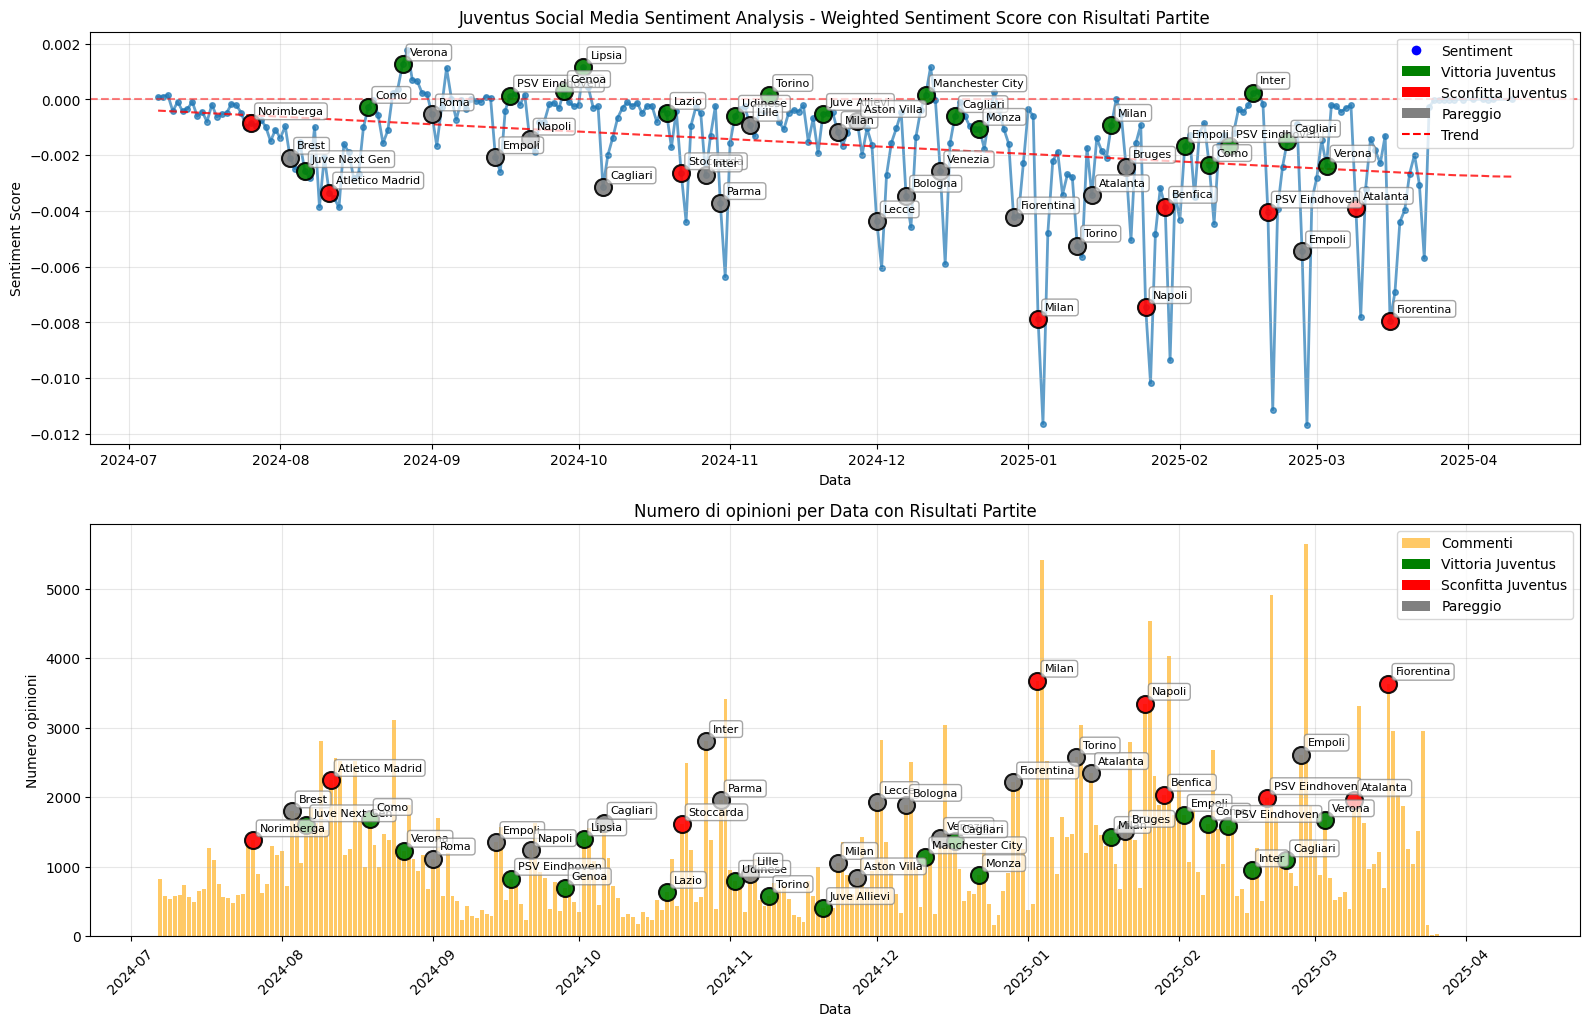


📊 STATISTICHE CRONOLOGICHE:
Periodo analizzato: 2024-07-07 → 2025-04-10
Numero di giorni con dati: 272
Sentiment medio pesato: -0.0016
Sentiment mediano pesato: -0.0009
Deviazione standard sentiment: 0.0021
Range sentiment: -0.0117 → 0.0018
Totale opinioni analizzati: 321087
Media opinioni per giorno: 1180.5

🏆 STATISTICHE PARTITE:
Totale partite nel periodo: 47
Vittorie: 20 | Sconfitte: 9 | Pareggi: 18
Percentuale vittorie: 42.6%

🔴 TOP 5 GIORNI PIÙ NEGATIVI:
  2025-02-27: -0.0117 (5649 opinioni)
  2025-01-04: -0.0116 (5412 opinioni)
  2025-02-20: -0.0111 (4913 opinioni)
  2025-01-26: -0.0102 (4543 opinioni)
  2025-01-30: -0.0094 (4033 opinioni)

🟢 TOP 5 GIORNI PIÙ POSITIVI:
  2024-08-27: 0.0018 (1890 opinioni)
  2024-08-26: 0.0013 (1229 opinioni)
  2024-10-02: 0.0012 (1393 opinioni)
  2024-12-12: 0.0012 (1229 opinioni)
  2024-09-04: 0.0011 (1197 opinioni)

📈 TOP 5 GIORNI CON PIÙ opinioni:
  2025-02-27: 5649 opinioni (sentiment: -0.0117)
  2025-01-04: 5412 opinioni (sentiment: -0.011

In [98]:
# Modifica della funzione plot_sentiment_chronologically per includere i risultati delle partite
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from datetime import datetime
import numpy as np
import json

# Carica i dati delle partite
def load_matches_data():
    """
    Carica i dati delle partite Juventus
    """
    try:
        with open('matches.json', 'r', encoding='utf-8') as f:
            matches = json.load(f)
        print(f"✅ Caricati {len(matches)} match data dal file matches.json")
    except FileNotFoundError:
        print("❌ File matches.json non trovato. Creando dati di esempio...")
    
    # Crea DataFrame e processa i dati
    df_matches = pd.DataFrame(matches)
    df_matches['date_obj'] = pd.to_datetime(df_matches['data'])
    df_matches = df_matches.sort_values('date_obj')
    
    def get_match_color(partita, risultato):
        """Determina il colore del match basato sul risultato per la Juventus"""
        scores = risultato.split('-')
        try:
            score1 = int(scores[0])
            score2 = int(scores[1])
        except ValueError:
            return 'gray'
        
        if 'Juventus' in partita.split('-')[0]:
            juventus_score = score1
            opponent_score = score2
        else:
            juventus_score = score2
            opponent_score = score1
        
        if juventus_score > opponent_score:
            return 'green'
        elif juventus_score < opponent_score:
            return 'red'
        else:
            return 'gray'
    
    df_matches['color'] = df_matches.apply(lambda row: get_match_color(row['partita'], row['risultato']), axis=1)
    return df_matches

# Funzione modificata per includere le partite
# ...existing code...
# Funzione modificata per includere le partite con etichette
def plot_sentiment_chronologically_with_matches(data_dict, title="Sentiment Analysis Over Time"):
    """
    Crea un grafico cronologico del sentiment con i risultati delle partite sovrapposti
    """
    # Carica i dati delle partite
    df_matches = load_matches_data()
    
    # Calcola i punteggi pesati per ogni data
    weighted_results = calculate_weighted_sentiment(data_dict)
    
    # Prepara i dati per il plotting
    dates = []
    sentiments = []
    comment_counts = []
    
    for date_str, scores in weighted_results.items():
        try:
            # Prova diversi formati di data
            try:
                date_obj = datetime.strptime(date_str, '%Y-%m-%d')
            except ValueError:
                try:
                    date_obj = datetime.strptime(date_str, '%d/%m/%Y')
                except ValueError:
                    try:
                        date_obj = datetime.strptime(date_str, '%m/%d/%Y')
                    except ValueError:
                        print(f"Formato data non riconosciuto: {date_str}")
                        continue
            
            dates.append(date_obj)
            sentiments.append(scores['weighted_sentiment'])
            comment_counts.append(scores['num_comments'])
        except Exception as e:
            print(f"Errore nel processare la data {date_str}: {e}")
            continue
    
    # Crea DataFrame per facilitare l'ordinamento
    df = pd.DataFrame({
        'date': dates,
        'sentiment': sentiments,
        'comments': comment_counts
    })
    
    # Ordina per data
    df = df.sort_values('date')
    
    # Funzione per estrarre il nome dell'avversario
    def get_opponent_name(partita):
        """Estrae il nome della squadra avversaria dalla stringa della partita"""
        teams = partita.split('-')
        if len(teams) == 2:
            if 'Juventus' in teams[0].strip():
                return teams[1].strip()
            else:
                return teams[0].strip()
        return partita  # Fallback se il formato non è riconosciuto
    
    # Crea il grafico
    plt.figure(figsize=(16, 10))
    
    # Plot principale del sentiment con partite
    plt.subplot(2, 1, 1)
    plt.plot(df['date'], df['sentiment'], marker='o', linewidth=2, markersize=4, alpha=0.7, label='Sentiment', zorder=1)
    
    # Sovrapponi i risultati delle partite con etichette
    for _, match_row in df_matches.iterrows():
        # Trova il sentiment più vicino a quella data
        closest_sentiment = 0  # Default se non ci sono dati sentiment per quella data
        if len(df) > 0:
            # Trova la data più vicina nel dataframe sentiment
            time_diffs = abs(df['date'] - match_row['date_obj'])
            closest_idx = time_diffs.idxmin()
            if time_diffs.loc[closest_idx].days <= 3:  # Solo se entro 3 giorni
                closest_sentiment = df.loc[closest_idx, 'sentiment']
        
        # Disegna il pallino
        plt.scatter(match_row['date_obj'], closest_sentiment, 
                   s=150, alpha=0.9, color=match_row['color'], 
                   edgecolors='black', linewidth=1.5, marker='o', zorder=10)
        
        # Aggiungi l'etichetta con il nome dell'avversario
        opponent_name = get_opponent_name(match_row['partita'])
        plt.annotate(opponent_name, 
                    (match_row['date_obj'], closest_sentiment),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, ha='left', va='bottom',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor='gray'),
                    zorder=15)
    
    plt.title(f'{title} - Weighted Sentiment Score con Risultati Partite')
    plt.xlabel('Data')
    plt.ylabel('Sentiment Score')
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
    
    # Aggiungi una linea di tendenza
    if len(df) > 1:
        z = np.polyfit(range(len(df)), df['sentiment'], 1)
        p = np.poly1d(z)
        plt.plot(df['date'], p(range(len(df))), "r--", alpha=0.8, 
                label=f'Trend (slope: {z[0]:.6f})')
    
    # Legenda per le partite
    from matplotlib.patches import Patch
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Sentiment'),
        Patch(facecolor='green', label='Vittoria Juventus'),
        Patch(facecolor='red', label='Sconfitta Juventus'),
        Patch(facecolor='gray', label='Pareggio')
    ]
    if len(df) > 1:
        legend_elements.append(plt.Line2D([0], [0], color='red', linestyle='--', label=f'Trend'))
    
    plt.legend(handles=legend_elements, loc='upper right')
    
    # Plot del numero di opinioni con partite
    plt.subplot(2, 1, 2)
    plt.bar(df['date'], df['comments'], alpha=0.6, color='orange', label='opinioni', zorder=1)
    
    # Sovrapponi i risultati delle partite con etichette
    max_comments = df['comments'].max() if len(df) > 0 else 100
    for _, match_row in df_matches.iterrows():
        # Trova il numero di opinioni più vicino a quella data
        closest_comments = max_comments * 0.1  # Default al 10% del massimo
        if len(df) > 0:
            time_diffs = abs(df['date'] - match_row['date_obj'])
            closest_idx = time_diffs.idxmin()
            if time_diffs.loc[closest_idx].days <= 3:  # Solo se entro 3 giorni
                closest_comments = df.loc[closest_idx, 'comments']
        
        # Disegna il pallino
        plt.scatter(match_row['date_obj'], closest_comments, 
                   s=150, alpha=0.9, color=match_row['color'], 
                   edgecolors='black', linewidth=1.5, marker='o', zorder=10)
        
        # Aggiungi l'etichetta con il nome dell'avversario
        opponent_name = get_opponent_name(match_row['partita'])
        plt.annotate(opponent_name, 
                    (match_row['date_obj'], closest_comments),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, ha='left', va='bottom',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor='gray'),
                    zorder=15)
    
    plt.title('Numero di opinioni per Data con Risultati Partite')
    plt.xlabel('Data')
    plt.ylabel('Numero opinioni')
    plt.grid(True, alpha=0.3)
    
    # Legenda per il secondo grafico
    legend_elements_2 = [
        plt.Rectangle((0,0),1,1, facecolor='orange', alpha=0.6, label='Commenti'),
        Patch(facecolor='green', label='Vittoria Juventus'),
        Patch(facecolor='red', label='Sconfitta Juventus'),
        Patch(facecolor='gray', label='Pareggio')
    ]
    plt.legend(handles=legend_elements_2, loc='upper right')
    
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()

    # Stampa statistiche (stesso codice di prima)
    print(f"\n📊 STATISTICHE CRONOLOGICHE:")
    print(f"Periodo analizzato: {df['date'].min().strftime('%Y-%m-%d')} → {df['date'].max().strftime('%Y-%m-%d')}")
    print(f"Numero di giorni con dati: {len(df)}")
    print(f"Sentiment medio pesato: {df['sentiment'].mean():.4f}")
    print(f"Sentiment mediano pesato: {df['sentiment'].median():.4f}")
    print(f"Deviazione standard sentiment: {df['sentiment'].std():.4f}")
    print(f"Range sentiment: {df['sentiment'].min():.4f} → {df['sentiment'].max():.4f}")
    print(f"Totale opinioni analizzati: {df['comments'].sum()}")
    print(f"Media opinioni per giorno: {df['comments'].mean():.1f}")
    
    # Statistiche partite
    wins = len(df_matches[df_matches['color'] == 'green'])
    losses = len(df_matches[df_matches['color'] == 'red'])
    draws = len(df_matches[df_matches['color'] == 'gray'])
    
    print(f"\n🏆 STATISTICHE PARTITE:")
    print(f"Totale partite nel periodo: {len(df_matches)}")
    print(f"Vittorie: {wins} | Sconfitte: {losses} | Pareggi: {draws}")
    print(f"Percentuale vittorie: {wins/len(df_matches)*100:.1f}%")
    
    # Identifica giorni con sentiment estremi
    print(f"\n🔴 TOP 5 GIORNI PIÙ NEGATIVI:")
    worst_days = df.nsmallest(5, 'sentiment')
    for _, row in worst_days.iterrows():
        print(f"  {row['date'].strftime('%Y-%m-%d')}: {row['sentiment']:.4f} ({row['comments']} opinioni)")
    
    print(f"\n🟢 TOP 5 GIORNI PIÙ POSITIVI:")
    best_days = df.nlargest(5, 'sentiment')
    for _, row in best_days.iterrows():
        print(f"  {row['date'].strftime('%Y-%m-%d')}: {row['sentiment']:.4f} ({row['comments']} opinioni)")
    
    print(f"\n📈 TOP 5 GIORNI CON PIÙ opinioni:")
    most_commented_days = df.nlargest(5, 'comments')
    for _, row in most_commented_days.iterrows():
        print(f"  {row['date'].strftime('%Y-%m-%d')}: {row['comments']} opinioni (sentiment: {row['sentiment']:.4f})")
    
    return df, df_matches

# Esegui il plotting cronologico con le partite
print("Creazione grafico cronologico del sentiment con risultati partite...")
chronological_df, matches_df = plot_sentiment_chronologically_with_matches(data_dict, "Juventus Social Media Sentiment Analysis")


🎨 Creazione visualizzazioni aggiuntive...


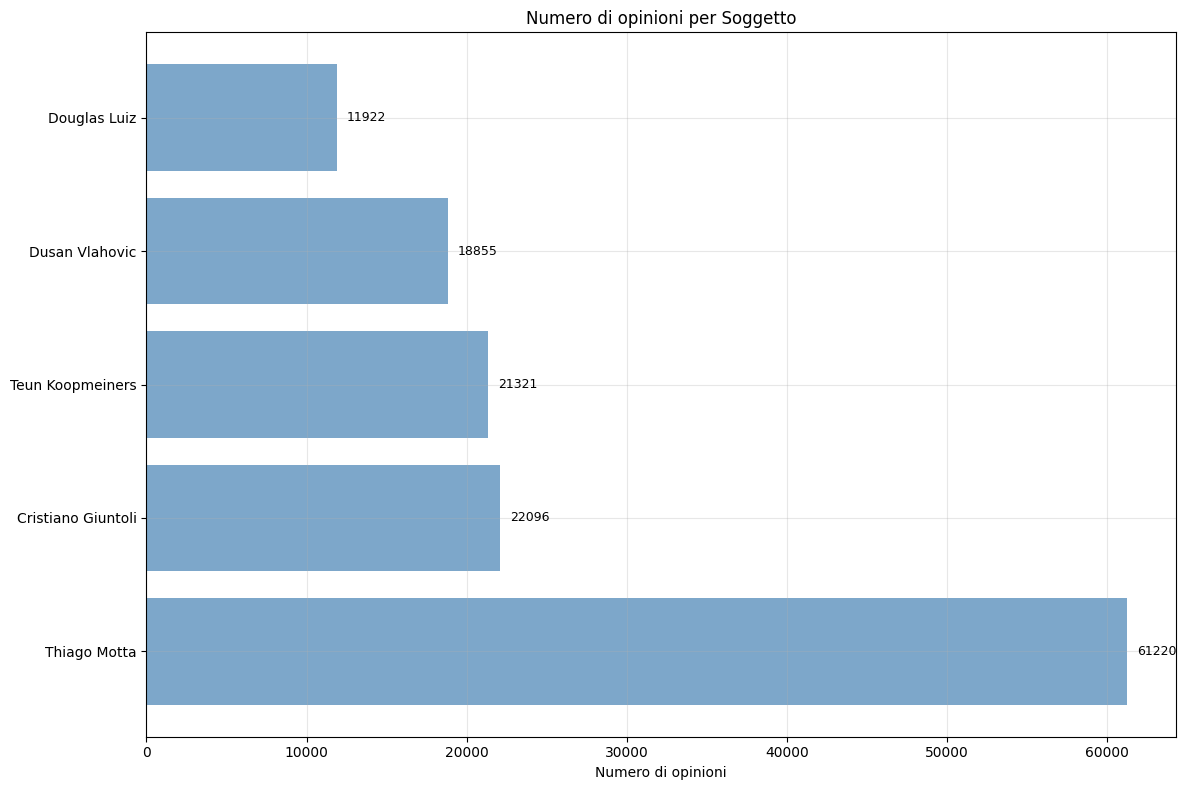

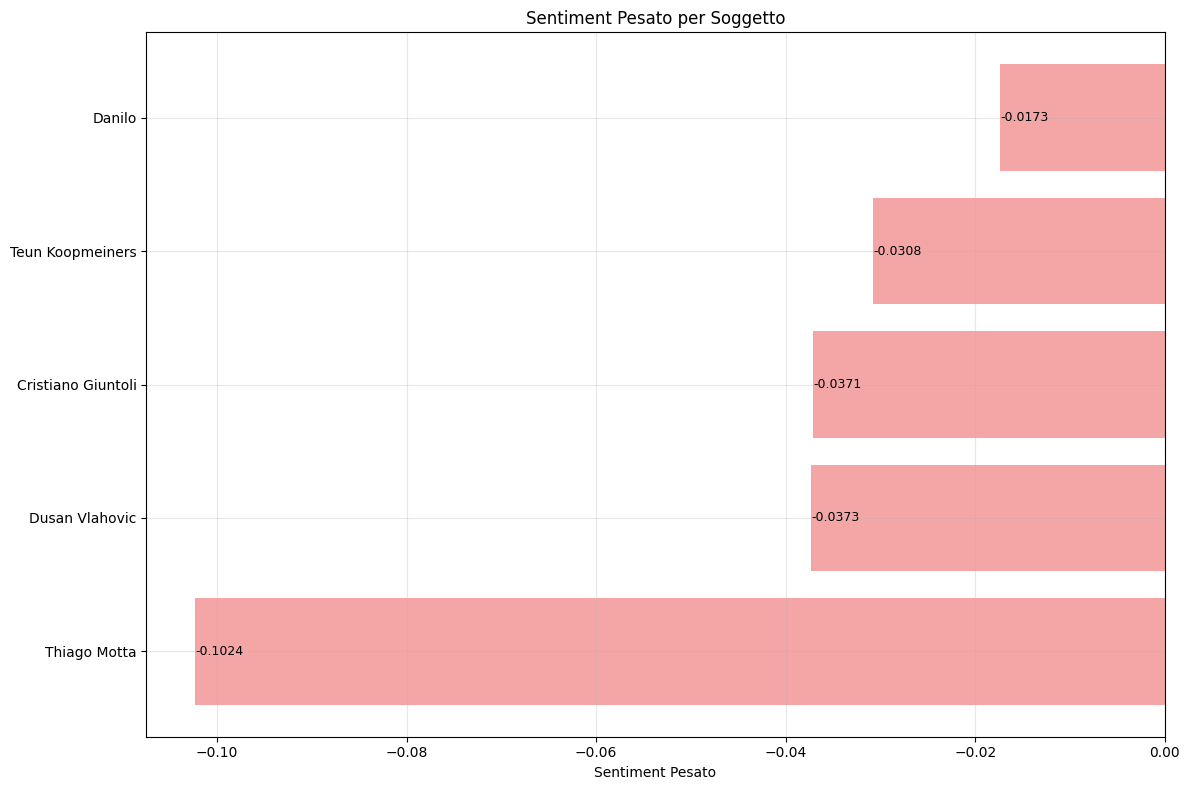

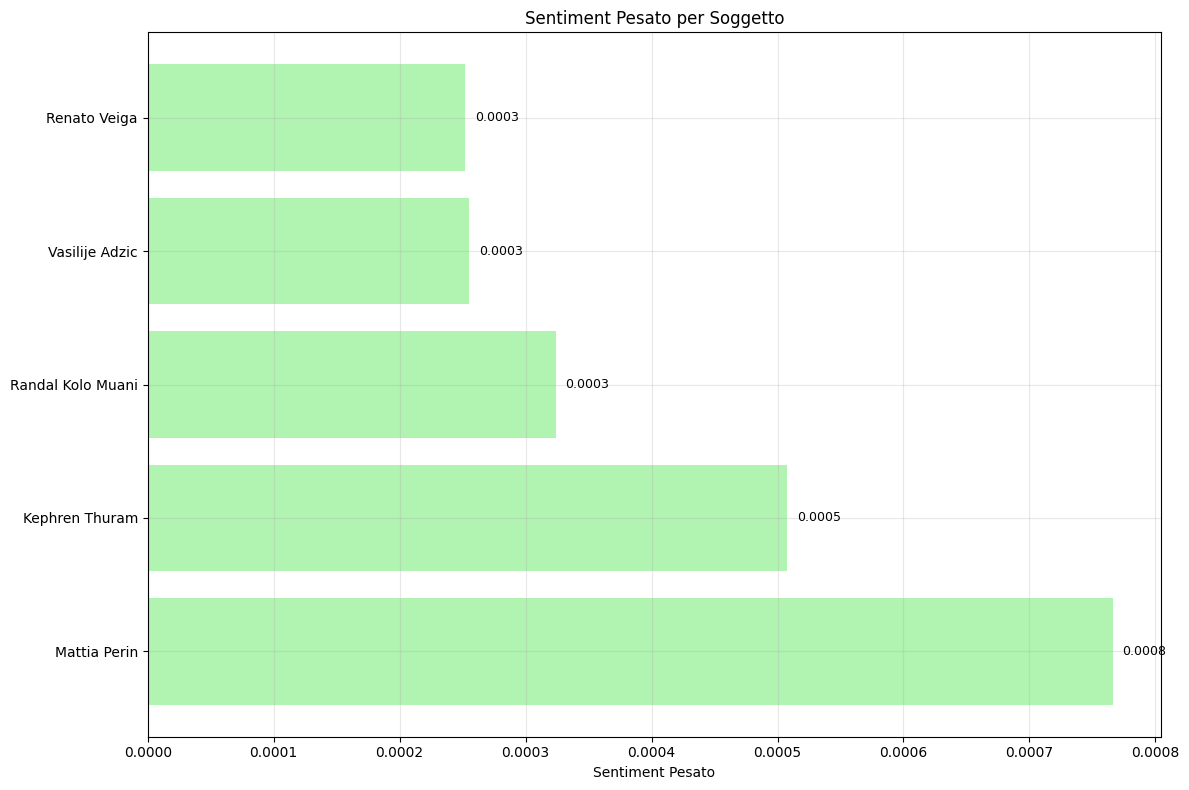


 📊 RAPPORTO RIASSUNTIVO SENTIMENT ANALYSIS - JUVENTUS

🔢 STATISTICHE GENERALI:
   • Totale opinioni analizzate: 321,087
   • Numero di giorni con dati: 272
   • Numero di commentatori unici: 26,211
   • Soggetti identificati: 33
   • Media opinioni per giorno: 1180.5

📈 SENTIMENT GLOBALE:
   • Sentiment medio pesato: -0.0131
   • Range sentiment: -0.1024 → 0.0008

👥 TOP 10 SOGGETTI PIÙ COMMENTATI:
    1. Thiago Motta         -  61220 opinioni (sentiment:  -0.1024)
    2. Cristiano Giuntoli   -  22096 opinioni (sentiment:  -0.0371)
    3. Teun Koopmeiners     -  21321 opinioni (sentiment:  -0.0308)
    4. Dusan Vlahovic       -  18855 opinioni (sentiment:  -0.0373)
    5. Douglas Luiz         -  11922 opinioni (sentiment:  -0.0125)
    6. Kenan Yildiz         -  10822 opinioni (sentiment:  -0.0044)
    7. Nico Gonzalez        -  10492 opinioni (sentiment:  -0.0134)
    8. Danilo               -   9009 opinioni (sentiment:  -0.0173)
    9. Manuel Locatelli     -   8425 opinioni (sentime

In [ ]:
# Funzioni aggiuntive per visualizzazioni del sentiment

def plot_sentiment_by_subject(soggetto_dict, top_n=15):
    """
    Crea un grafico del sentiment per i soggetti più commentati
    """
    # Calcola i punteggi pesati per soggetti
    weighted_results = calculate_weighted_sentiment(soggetto_dict)
    
    # Ordina per numero di opinioni e prendi i top N
    sorted_subjects = sorted(weighted_results.items(), 
                           key=lambda x: x[1]['num_comments'], 
                           reverse=True)
    
    subjects = [item[0] for item in sorted_subjects if item[0] not in ["Juventus", "Squadra", "Dirigenza"]][:top_n]
    comments = [item[1]['num_comments'] for item in sorted_subjects if item[0] not in ["Juventus", "Squadra", "Dirigenza"]][:top_n]
    
    # Crea il grafico
    fig, ax2 = plt.subplots(figsize=(12, 8))

    # Grafico numero opinioni
    bars2 = ax2.barh(subjects, comments, color='steelblue', alpha=0.7)
    ax2.set_xlabel('Numero di opinioni')
    ax2.set_title('Numero di opinioni per Soggetto')
    ax2.grid(True, alpha=0.3)

    # Aggiungi valori sulle barre
    for bar, comm in zip(bars2, comments):
        width = bar.get_width()
        ax2.text(width + max(comments)*0.01, bar.get_y() + bar.get_height()/2, 
                str(comm), ha='left', va='center', fontsize=9)

    plt.tight_layout()
    plt.show()
    
    fig, ax2 = plt.subplots(figsize=(12, 8))
    sorted_subjects = sorted(weighted_results.items(),
                           key=lambda x: x[1]['weighted_sentiment'], 
                           reverse=False)
    subjects = [item[0] for item in sorted_subjects if item[0] not in ["Juventus", "Squadra", "Dirigenza"]][:top_n]
    weighted_sentiments = [item[1]['weighted_sentiment'] for item in sorted_subjects if item[0] not in ["Juventus", "Squadra", "Dirigenza"]][:top_n]
    sentiments = [item[1]['weighted_sentiment'] for item in sorted_subjects]
    # Grafico sentiment pesato
    bars = ax2.barh(subjects, weighted_sentiments, color='lightcoral', alpha=0.7)
    ax2.set_xlabel('Sentiment Pesato')
    ax2.set_title('Sentiment Pesato per Soggetto')
    ax2.grid(True, alpha=0.3)
    # Aggiungi valori sulle barre
    for bar, sentiment in zip(bars, weighted_sentiments):
        width = bar.get_width()
        ax2.text(width + max(sentiments)*0.01, bar.get_y() + bar.get_height()/2, 
                f"{sentiment:.4f}", ha='left', va='center', fontsize=9)
    plt.tight_layout()
    plt.show()
    
    fig, ax2 = plt.subplots(figsize=(12, 8))
    
    sorted_subjects = sorted(weighted_results.items(),
                           key=lambda x: x[1]['weighted_sentiment'], 
                           reverse=True)
    subjects = [item[0] for item in sorted_subjects if item[0] not in ["Juventus", "Squadra", "Dirigenza"]][:top_n]
    weighted_sentiments = [item[1]['weighted_sentiment'] for item in sorted_subjects if item[0] not in ["Juventus", "Squadra", "Dirigenza"]][:top_n]
    sentiments = [item[1]['weighted_sentiment'] for item in sorted_subjects]
    # Grafico sentiment pesato
    bars = ax2.barh(subjects, weighted_sentiments, color='lightgreen', alpha=0.7)
    ax2.set_xlabel('Sentiment Pesato')
    ax2.set_title('Sentiment Pesato per Soggetto')
    ax2.grid(True, alpha=0.3)
    # Aggiungi valori sulle barre
    for bar, sentiment in zip(bars, weighted_sentiments):
        width = bar.get_width()
        ax2.text(width + max(sentiments)*0.01, bar.get_y() + bar.get_height()/2, 
                f"{sentiment:.4f}", ha='left', va='center', fontsize=9)
    plt.tight_layout()
    plt.show()
    
    return dict(sorted_subjects)



def create_sentiment_summary_table(soggetto_dict, data_dict, commentatore_dict):
    """
    Crea una tabella riassuntiva del sentiment
    """
    # Calcola statistiche per soggetti
    subject_results = calculate_weighted_sentiment(soggetto_dict)
    
    # Calcola statistiche generali
    total_comments = sum(len(items) for items in soggetto_dict.values())
    total_days = len(data_dict)
    total_commenters = len(commentatore_dict)
    
    # Statistiche sentiment
    all_sentiments = [scores['weighted_sentiment'] for scores in subject_results.values()]
    avg_sentiment = np.mean(all_sentiments)
    
    print("\n" + "="*80)
    print(" 📊 RAPPORTO RIASSUNTIVO SENTIMENT ANALYSIS - JUVENTUS")
    print("="*80)
    
    print(f"\n🔢 STATISTICHE GENERALI:")
    print(f"   • Totale opinioni analizzate: {total_comments:,}")
    print(f"   • Numero di giorni con dati: {total_days}")
    print(f"   • Numero di commentatori unici: {total_commenters:,}")
    print(f"   • Soggetti identificati: {len(soggetto_dict)}")
    print(f"   • Media opinioni per giorno: {total_comments/total_days:.1f}")
    
    print(f"\n📈 SENTIMENT GLOBALE:")
    print(f"   • Sentiment medio pesato: {avg_sentiment:.4f}")
    print(f"   • Range sentiment: {min(all_sentiments):.4f} → {max(all_sentiments):.4f}")
    
    # Top soggetti per numero opinioni
    top_commented = sorted(subject_results.items(), key=lambda x: x[1]['num_comments'], reverse=True)
    print(f"\n👥 TOP 10 SOGGETTI PIÙ COMMENTATI:")
    counter = 0
    for i, (subject, data) in enumerate(top_commented, 1):
        if counter >= 10:
            break
        if subject == "Juventus" or subject == "Squadra" or subject == "Dirigenza":
            continue
        counter += 1
        print(f"   {counter:2d}. {subject:<20} - {data['num_comments']:>6} opinioni (sentiment: {data['weighted_sentiment']:>8.4f})")
    
    # Soggetti più positivi (con almeno 100 opinioni)
    positive_subjects = [(s, d) for s, d in subject_results.items() 
                        if d['num_comments'] >= 100 and d['weighted_sentiment'] > 0]
    positive_subjects.sort(key=lambda x: x[1]['weighted_sentiment'], reverse=True)
    
    print(f"\n🟢 SOGGETTI PIÙ POSITIVI (min. 100 opinioni):")
    if positive_subjects:
        for i, (subject, data) in enumerate(positive_subjects[:5], 1):
            print(f"   {i}. {subject:<20} - Sentiment: {data['weighted_sentiment']:>8.4f} ({data['num_comments']} opinioni)")
    else:
        print("   ⚠️ Nessun soggetto con sentiment positivo e almeno 100 opinioni")
    
    # Soggetti più negativi (con almeno 100 opinioni)
    negative_subjects = [(s, d) for s, d in subject_results.items() 
                        if d['num_comments'] >= 100]
    negative_subjects.sort(key=lambda x: x[1]['weighted_sentiment'])
    print(f"\n🔴 SOGGETTI PIÙ NEGATIVI (min. 100 opinioni):")
    counter = 0
    for i, (subject, data) in enumerate(negative_subjects, 1):
        if counter >= 5:
            break
        if subject == "Juventus" or subject == "Squadra" or subject == "Dirigenza" or subject == "Danilo":
            continue
        counter += 1
        print(f"   {counter}. {subject:<20} - Sentiment: {data['weighted_sentiment']:>8.4f} ({data['num_comments']} opinioni)")
    
    print("\n" + "="*80)

# Esegui le visualizzazioni aggiuntive
print("\n🎨 Creazione visualizzazioni aggiuntive...")

# Grafico per soggetti
top_subjects_data = plot_sentiment_by_subject(soggetto_dict, top_n=5)

# Tabella riassuntiva
create_sentiment_summary_table(soggetto_dict, data_dict, commentatore_dict)